# Train Micro Activity Masking Classifiers

In [1]:
import glob
import os
import numpy as np
import csv
import io
from sklearn.preprocessing import StandardScaler
import shutil

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [14]:
# Options to set for GPU machine

In [2]:
# from keras.backend.tensorflow_backend import set_session
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config.log_device_placement = True  # to log device placement (on which device the operation ran)
# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default

In [2]:
sub_dirs = ['left_hip','right_arm','right_wrist'] #three sensors, 9 channels total

In [3]:
#correcting the buckets information

def parse_IMU_files(parent_dir, sub_dirs, startTime, endTime, file_name, window_length):
    
    data = []
    data_mask = []
    
    data_count = 0
    
    for sub_dir in sub_dirs:
        
        channel=[[0.0, 0.0, 0.0]]*window_length
        
        mask = [0.0]*window_length
        
        div_bucket = int(10000/window_length)
        
        for fn in glob.glob(os.path.join(parent_dir,sub_dir, file_name)):
            file = open(fn, newline='')
            reader = csv.reader(file)
            first = True
            count = 0
            for row in reader:
                
                if first:
                    first = False
                    continue
                
                timestamp=float(row[3]) #4th column is timestamp
                if timestamp >=startTime and timestamp <=endTime and count<window_length:
                    
                    curr_bucket = timestamp - startTime #can go from 0 to 10,000
                    
                    curr_bucket = int(curr_bucket/div_bucket) #can go from 0 to 500
                    
                    #print('curr_bucket :',curr_bucket)
                    #channel.append([float(row[0]),float(row[1]),float(row[2])])
                    
                    if curr_bucket<window_length:
                        channel[curr_bucket] = [float(row[0]),float(row[1]),float(row[2])]
                        mask[curr_bucket] = 1.0

                        count = count + 1 
                        data_count = data_count+1
                    
                    
        data.append(channel) 
        data_mask.append(mask)
    return data, data_mask, data_count



#correcting the buckets information

import random

def parse_IMU_files_2(parent_dir, sub_dirs, startTime, endTime, file_name, window_length):
    
    data = []
    data_mask = []
    
    data_count = 0
    
    for sub_dir in sub_dirs:
        
        channel=[[0.0, 0.0, 0.0]]*window_length
        
        mask = [0.0]*window_length
        
        div_bucket = int(10000/window_length)
        
        for fn in glob.glob(os.path.join(parent_dir,sub_dir, file_name)):
            file = open(fn, newline='')
            reader = csv.reader(file)
            first = True
            count = 0
            for row in reader:
                
                if first:
                    first = False
                    continue
                
                timestamp=float(row[3]) #4th column is timestamp
                
                window_jitter1 = random.randint(-150,150)
                
                window_jitter2 = random.randint(-150,150)
                
                
                if timestamp >=(startTime+window_jitter1) and timestamp <=(endTime+window_jitter2) and count<window_length:
                    
                    curr_bucket = timestamp - startTime #can go from 0 to 10,000
                    
                    curr_bucket = int(curr_bucket/div_bucket) #can go from 0 to 500
                    
                    if curr_bucket<window_length:
                        channel[curr_bucket] = [float(row[0]),float(row[1]),float(row[2])]
                        mask[curr_bucket] = 1.0

                        count = count + 1 
                        data_count = data_count+1                   
                    
        data.append(channel) 
        data_mask.append(mask)
    return data, data_mask, data_count



def parse_IMU_files_3(parent_dir, sub_dirs, startTime, endTime, file_name, window_length):
    
    data = []
    data_mask = []
    
    data_count = 0
    
    for sub_dir in sub_dirs:
        
        channel=[[0.0, 0.0, 0.0]]*window_length
        
        mask = [0.0]*window_length
        
        div_bucket = int(10000/window_length)
        
        window_jitter1 = random.randint(-1500,1500)
        window_jitter2 = random.randint(-1500,1500)
                
        
        for fn in glob.glob(os.path.join(parent_dir,sub_dir, file_name)):
            file = open(fn, newline='')
            reader = csv.reader(file)
            first = True
            count = 0
            for row in reader:
                
                if first:
                    first = False
                    continue
                
                timestamp=float(row[3]) #4th column is timestamp
                
                
                if timestamp >=(startTime+window_jitter1) and timestamp <=(endTime+window_jitter2) and count<window_length:
                    
                    curr_bucket = timestamp - startTime #can go from 0 to 10,000
                    
                    curr_bucket = int(curr_bucket/div_bucket) #can go from 0 to 500
                    
                    if curr_bucket<window_length:
                        channel[curr_bucket] = [float(row[0]),float(row[1]),float(row[2])]
                        mask[curr_bucket] = 1.0

                        count = count + 1 
                        data_count = data_count+1                   
                    
        data.append(channel) 
        data_mask.append(mask)
    return data, data_mask, data_count

In [4]:
data_min_count = 100 # per sample, valid points

In [5]:
def get_train_data(data_dir, sub_dirs, pos_lab, neg_lab, labeltable):
    files = os.listdir(data_dir+'/left_hip')
    number_of_samples = 500
    
    labels_macro =dict()
    
    labels_macro[pos_lab] = 0
    labels_macro[neg_lab] = 1
    
    
    #read the labels
    labels_loc = labeltable
    file_label = open(labels_loc, newline='')
    label_reader = csv.reader(file_label)
    file_label_mapping = dict()
    
    first = True
    for row in label_reader:
        
        if first:
            first = False
            continue
        
        file_label_mapping[row[0]+'.csv'] = labels_macro[row[2]]
        
    all_data = []
    all_labels = []
    all_filename = []
    for f in files:
        
        st_index = 0
        end_index = 30000
        step = 1000 #overlapping window, step: 1000. 
        window_index = 10000 #6 second window
        
        #print('reading file:',f)
        f_name = f
        
        if f_name == '.DS_Store':
            continue
        
        curr_label_file = file_label_mapping[f_name]
        
        while st_index+step < end_index:
        
            data, data_mask, data_count = parse_IMU_files(data_dir, sub_dirs, st_index, st_index+window_index,  f, number_of_samples)
            st_index = st_index+step
            
            if data_count<data_min_count:
                continue
            
            train_data_sample  = np.zeros((12, number_of_samples))
            train_data_label   = curr_label_file
            for i in range(len(data)):
                for j in range(len(data[i])):
                    train_data_sample[i*4,j]=data[i][j][0]
                    train_data_sample[i*4+1,j]=data[i][j][1]
                    train_data_sample[i*4+2,j]=data[i][j][2]
                    
                    #mask information
                    train_data_sample[i*4+3,j]=data_mask[i][j]
                    
                    
            all_filename.append(f_name)
            all_data.append(train_data_sample)
            all_labels.append(train_data_label)
            
            
            
    return all_data, all_labels, all_filename


def get_train_data_2(data_dir, sub_dirs,pos_lab, neg_lab, labeltable):
    files = os.listdir(data_dir+'/left_hip')
    number_of_samples = 500
    
    labels_macro =dict()
    
    labels_macro[pos_lab] = 0
    labels_macro[neg_lab] = 1
    
    
    #read the labels
    labels_loc = labeltable
    file_label = open(labels_loc, newline='')
    label_reader = csv.reader(file_label)
    file_label_mapping = dict()
    
    first = True
    for row in label_reader:
        
        if first:
            first = False
            continue
        
        file_label_mapping[row[0]+'.csv'] = labels_macro[row[2]]
        
    all_data = []
    all_labels = []
    
    all_counts = []
    
    for f in files:
        
        st_index = 0
        end_index = 30000
        step = 1000 #overlapping window, step 
        window_index = 10000 #6 second window
        
        #print('reading file:',f)
        f_name = f
        
        if f_name == '.DS_Store':
            continue
        
        curr_label_file = file_label_mapping[f_name]
        
        while st_index+step < end_index:
        
            data, data_mask, data_count = parse_IMU_files_2(data_dir, sub_dirs, st_index, st_index+window_index,  f, number_of_samples)
            
            st_index = st_index+step
            
            if data_count<data_min_count:
                continue
            
            train_data_sample  = np.zeros((12, number_of_samples))
            train_data_label   = curr_label_file
            for i in range(len(data)):
                for j in range(len(data[i])):
                    train_data_sample[i*4,j]=data[i][j][0]
                    train_data_sample[i*4+1,j]=data[i][j][1]
                    train_data_sample[i*4+2,j]=data[i][j][2]
                    
                    #mask information
                    train_data_sample[i*4+3,j]=data_mask[i][j]
            
            all_data.append(train_data_sample)
            all_labels.append(train_data_label)
            
            all_counts.append(data_count)
            
            
            
    return all_data, all_labels, all_counts


def get_train_data_3(data_dir, sub_dirs,pos_lab, neg_lab, labeltable):
    files = os.listdir(data_dir+'/left_hip')
    number_of_samples = 500
    
    labels_macro =dict()
    
    labels_macro[pos_lab] = 0
    labels_macro[neg_lab] = 1
    
    
    #read the labels
    labels_loc = labeltable
    file_label = open(labels_loc, newline='')
    label_reader = csv.reader(file_label)
    file_label_mapping = dict()
    
    first = True
    for row in label_reader:
        
        if first:
            first = False
            continue
        
        file_label_mapping[row[0]+'.csv'] = labels_macro[row[2]]
        
    all_data = []
    all_labels = []
    
    all_counts = []
    for f in files:
        
        st_index = 0
        end_index = 30000
        step = 1000 #overlapping window, step: 1000. 
        window_index = 10000 #6 second window
        
        #print('reading file:',f)
        f_name = f
        
        if f_name == '.DS_Store':
            continue
        
        curr_label_file = file_label_mapping[f_name]
        
        while st_index+step < end_index:
                
            
            data, data_mask, data_count  = parse_IMU_files_3(data_dir, sub_dirs, st_index, st_index+window_index,  f, number_of_samples)
            
            st_index = st_index+step
            
            if data_count<data_min_count:
                continue
            
            train_data_sample  = np.zeros((12, number_of_samples))
            train_data_label   = curr_label_file
            for i in range(len(data)):
                for j in range(len(data[i])):
                    train_data_sample[i*4,j]=data[i][j][0]
                    train_data_sample[i*4+1,j]=data[i][j][1]
                    train_data_sample[i*4+2,j]=data[i][j][2]
                    
                    #mask information
                    train_data_sample[i*4+3,j]=data_mask[i][j]
                    

            all_data.append(train_data_sample)
            all_labels.append(train_data_label)
            
            all_counts.append(data_count)
            
            
    return all_data, all_labels, all_counts

In [6]:
def get_prediction_accuracy(data_dir, sub_dirs,pos_lab,neg_lab,labeltable,model):

    files = os.listdir(data_dir+'/left_hip')
    number_of_samples = 500

    labels_macro =dict()

    labels_macro[pos_lab] = 0
    labels_macro[neg_lab] = 1


    #read the labels
    labels_loc = labeltable
    file_label = open(labels_loc, newline='')
    label_reader = csv.reader(file_label)
    file_label_mapping = dict()

    first = True
    for row in label_reader:

        if first:
            first = False
            continue

        file_label_mapping[row[0]+'.csv'] = labels_macro[row[2]]


    total_count = 0
    correct_count = 0

    for f in files:

        file_data = []
        file_label = []

        st_index = 0
        end_index = 30000
        step = 1000 #overlapping window, step: 1000. 
        window_index = 10000 #6 second window

        #print('reading file:',f)
        f_name = f

        if f_name == '.DS_Store':
            continue

        total_count = total_count+1

        curr_label_file = file_label_mapping[f_name]

        while st_index+step < end_index:

            data, data_mask, data_count = parse_IMU_files(data_dir, sub_dirs, st_index, st_index+window_index,  f, number_of_samples)
            st_index = st_index+step

            if data_count<data_min_count:
                continue

            train_data_sample  = np.zeros((12, number_of_samples))
            train_data_label   = curr_label_file
            for i in range(len(data)):
                for j in range(len(data[i])):
                    train_data_sample[i*4,j]=data[i][j][0]
                    train_data_sample[i*4+1,j]=data[i][j][1]
                    train_data_sample[i*4+2,j]=data[i][j][2]
                    
                    #mask information
                    train_data_sample[i*4+3,j]=data_mask[i][j]

            file_data.append(train_data_sample)
            #file_label.append(train_data_label)

        file_data = np.array(file_data)
        file_label = curr_label_file

        file_data = file_data.reshape((-1, 12,500, 1))

        y_pred = np.argmax(model.predict(file_data), axis=1) 
        counts = np.bincount(y_pred)
        prediction = np.argmax(counts) #max occuring value in windows
        
        #correct prediction
        if int(prediction)==int(file_label):
            correct_count = correct_count+1
        
    
    return total_count, correct_count

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Permute, Reshape
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [8]:
def _data_reshaping(X_tr, X_va, X_ts, network_type):
    _, win_len, dim = X_tr.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':

        X_tr = np.swapaxes(X_tr,1,2)
        X_va = np.swapaxes(X_va,1,2)
        X_ts = np.swapaxes(X_ts,1,2)

        X_tr = np.reshape(X_tr, (-1, dim, win_len, 1))
        X_va = np.reshape(X_va, (-1, dim, win_len, 1))
        X_ts = np.reshape(X_ts, (-1, dim, win_len, 1))
    
    return X_tr, X_va, X_ts

In [9]:
from keras import regularizers

def model_variant(model, num_feat_map, dim, network_type,p):
    print(network_type)
    if network_type == 'ConvLSTM':
        model.add(Permute((2, 1, 3))) 
        model.add(Reshape((-1,num_feat_map*dim)))
        model.add(Bidirectional(LSTM(128, return_sequences=False, stateful=False)))
    if network_type == 'CNN':
        
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization()) 
        model.add(Dropout(p))

        
def model_conv(model, num_feat_map,p,b):
    model.add(Conv2D(num_feat_map, kernel_size=(1, 10),    
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    
    model.add(Conv2D(num_feat_map, kernel_size=(1, 10), activation='relu',padding='same'))
    
    if (b==1):
        model.add(BatchNormalization()) 
    model.add(Conv2D(num_feat_map, kernel_size=(1, 10), activation='relu',padding='same'))
    
    if (b==1):
        model.add(BatchNormalization()) 
    model.add(MaxPooling2D(pool_size=(1, 3)))
    
    model.add(Conv2D(num_feat_map, kernel_size=(1, 10), activation='relu',padding='same')) 
    model.add(Conv2D(num_feat_map, kernel_size=(1, 10), activation='relu',padding='same'))
    if (b==1):
        model.add(BatchNormalization()) 
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    
    model.add(Conv2D(num_feat_map, kernel_size=(1, 10), activation='relu',padding='same'))  
    if (b==1):
        model.add(BatchNormalization()) 
    model.add(MaxPooling2D(pool_size=(1, 2)))
    
    model.add(Dropout(p))
    
def model_LSTM(model,p):
    model.add(LSTM(num_hidden_lstm, 
               input_shape=(win_len,dim), 
               return_sequences=True))
    model.add(Dropout(p))
    model.add(LSTM(num_hidden_lstm, return_sequences=False))
    model.add(Dropout(p))
    
def model_output(model):
    model.add(Dense(num_classes, activation='softmax'))

In [10]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import itertools

class monitor_Training(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        return
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, epoch, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.argmax(self.model.predict(X_test), axis=1)
        accuracy = accuracy_score(y_true, y_pred)
        print('test accuracy is:', accuracy)
        return
 
    def on_batch_begin(self, batch, logs={}):
        return
 
    def on_batch_end(self, batch, logs={}):
        return

# Training/Testing:

Add

In [11]:
data_dir_train='data_micro/data_m_add_TTV/train'
data_dir_val= 'data_micro/data_m_add_TTV/val'
data_dir_test='data_micro/data_m_add_TTV/test'
pos_lab = 'Add'
neg_lab = 'No'
labelfile = 'LabelAdd.csv'
model_name = "data_micro/DCBL_micro_ADD_jitter_mask.hdf5"

In [12]:
#receive windowed training and validation data
train_x, train_y, train_files = get_train_data(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
val_x, val_y, val_files = get_train_data(data_dir_val,sub_dirs,pos_lab,neg_lab,labelfile)
test_x, test_y, test_files = get_train_data(data_dir_test,sub_dirs,pos_lab,neg_lab,labelfile)
train_x2, train_y2, all_counts = get_train_data_2(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
train_x3, train_y3, all_counts = get_train_data_3(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)

In [13]:
train_samples_2 = np.array(train_x2) 
train_labels2_2 = np.array(train_y2)
print(train_samples_2.shape)
print(train_labels2_2.shape)
train_samples_3 = np.array(train_x3) 
train_labels2_3 = np.array(train_y3)
print(train_samples_3.shape)
print(train_labels2_3.shape)
train_samples = np.array(train_x) 
train_labels2 = np.array(train_y)
val_samples = np.array(val_x) 
val_labels2 = np.array(val_y)
test_samples = np.array(test_x) 
test_labels2 = np.array(test_y)
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)
train_samples = np.vstack((train_samples,train_samples_2, train_samples_3))
train_labels2 = np.hstack((train_labels2, train_labels2_2, train_labels2_3))

(5053, 12, 500)
(5053,)
(5052, 12, 500)
(5052,)
(5054, 12, 500)
(5054,)
(1382, 12, 500)
(1382,)
(1378, 12, 500)
(1378,)


In [14]:
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15159, 12, 500)
(15159,)
(1382, 12, 500)
(1382,)
(1378, 12, 500)
(1378,)


In [15]:
#convert to one hot encoding
from keras.utils  import to_categorical
train_labels = to_categorical(train_labels2)
train_labels.shape
val_labels = to_categorical(val_labels2)
val_labels.shape
test_labels = to_categorical(test_labels2)
test_labels.shape
print(train_samples.shape)
print(train_labels.shape)
print(val_samples.shape)
print(val_labels.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15159, 12, 500)
(15159, 2)
(1382, 12, 500)
(1382, 2)
(1378, 12, 500)
(1378,)


In [16]:
#For CNN and BidirLSTM:
number_of_samples = 500
train_samples = train_samples.reshape((-1, 12,number_of_samples, 1))
val_samples = val_samples.reshape((-1, 12,number_of_samples, 1))
test_samples = test_samples.reshape((-1, 12,number_of_samples, 1))
#For LSTM, uncomment these lines and comment above two lines
#train_samples = train_samples.reshape((-1, number_of_samples, 9))
#val_samples = val_samples.reshape((-1, number_of_samples, 9))

#9 refers to 9 accelerometer channels

In [17]:
batch_size = 64
num_feat_map = 128
num_hidden_lstm = 128
num_classes = 2

#Uncomment the classifier you are working with:
#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#for CNN/DCBL
_, dim, win_len,_ = train_samples.shape
#for LSTM uncomment the following line and comment above line
#_, dim, win_len = train_samples.shape

print(win_len)
print(dim)

500
12


In [18]:
p=0.5 #Dropout
b = 1 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
       
model_output(model)    
model.summary()

building the model ... 
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

ConvLSTM
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 500, 128)      1408      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 500, 128)      512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 500, 128)      512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 166, 128)      0         
_____

In [19]:
X_train = train_samples
y_train = train_labels
X_val = val_samples
y_val = val_labels
X_test = test_samples
y_test = test_labels

In [20]:
print(X_train.shape, X_val.shape, X_test.shape)

(15159, 12, 500, 1) (1382, 12, 500, 1) (1378, 12, 500, 1)


In [21]:
y_true = np.argmax(y_test, axis=1)

In [3]:
epochs = 10

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# checkpoint
filepath=model_name

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks_list = [checkpoint]

H = model.fit(train_samples, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_val, y_val),
             callbacks=callbacks_list
             )

In [23]:
history = H

0


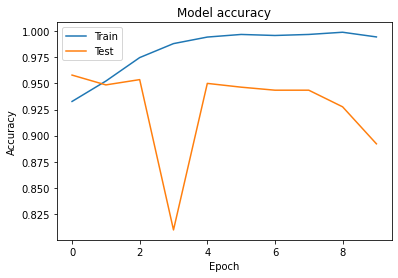

Maximum validation accuracy:  0.9580318331718445
Training accuracy of best model:  0.9327792


In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
print(np.argmax(np.array(history.history['val_accuracy'])))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Maximum validation accuracy: ',np.max(np.array(history.history['val_accuracy'])))
print('Training accuracy of best model: ',np.array(history.history['accuracy'])[np.argmax(np.array(history.history['val_accuracy']))])



In [25]:
model = load_model(model_name)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
accuracy = accuracy_score(y_true, y_pred)


print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))


[[   0   84]
 [   0 1294]]
the mean-f1 score: 0.48
accuracy is: 0.94


In [28]:
# Test data accuracy:
total_count, correct_count = get_prediction_accuracy(data_dir_test, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of test files:', total_count)
print('correctly predicted test files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
# Train accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_train, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of train files:', total_count)
print('correctly predicted train files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
#val accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_val, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of val files:', total_count)
print('correctly predicted val files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)

total_count of test files: 50
correctly predicted test files: 47
Percentage accuracy: 94.0
total_count of train files: 188
correctly predicted train files: 175
Percentage accuracy: 93.08510638297872
total_count of val files: 50
correctly predicted val files: 48
Percentage accuracy: 96.0


In [29]:
del train_x, train_y, train_files, val_x, val_y, val_files, test_x, test_y,test_files
del train_x2, train_y2, all_counts
del train_x3, train_y3

Cut

In [30]:
data_dir_train='data_micro/data_m_cut_TTV/train'
data_dir_val= 'data_micro/data_m_cut_TTV/val'
data_dir_test='data_micro/data_m_cut_TTV/test'
pos_lab = 'Cut'
neg_lab = 'No'
labelfile = 'LabelCut.csv'
model_name = "data_micro/DCBL_micro_Cut_jitter_mask.hdf5"

In [32]:
#receive windowed training and validation data
train_x, train_y, train_files = get_train_data(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
val_x, val_y, val_files = get_train_data(data_dir_val,sub_dirs,pos_lab,neg_lab,labelfile)
test_x, test_y, test_files = get_train_data(data_dir_test,sub_dirs,pos_lab,neg_lab,labelfile)
train_x2, train_y2, all_counts = get_train_data_2(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
train_x3, train_y3, all_counts = get_train_data_3(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)

In [33]:
train_samples_2 = np.array(train_x2) 
train_labels2_2 = np.array(train_y2)
print(train_samples_2.shape)
print(train_labels2_2.shape)
train_samples_3 = np.array(train_x3) 
train_labels2_3 = np.array(train_y3)
print(train_samples_3.shape)
print(train_labels2_3.shape)
train_samples = np.array(train_x) 
train_labels2 = np.array(train_y)
val_samples = np.array(val_x) 
val_labels2 = np.array(val_y)
test_samples = np.array(test_x) 
test_labels2 = np.array(test_y)
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)
train_samples = np.vstack((train_samples,train_samples_2, train_samples_3))
train_labels2 = np.hstack((train_labels2, train_labels2_2, train_labels2_3))

(5073, 12, 500)
(5073,)
(5060, 12, 500)
(5060,)
(5071, 12, 500)
(5071,)
(1416, 12, 500)
(1416,)
(1327, 12, 500)
(1327,)


In [34]:
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15204, 12, 500)
(15204,)
(1416, 12, 500)
(1416,)
(1327, 12, 500)
(1327,)


In [35]:
#convert to one hot encoding
from keras.utils  import to_categorical
train_labels = to_categorical(train_labels2)
train_labels.shape
val_labels = to_categorical(val_labels2)
val_labels.shape
test_labels = to_categorical(test_labels2)
test_labels.shape
print(train_samples.shape)
print(train_labels.shape)
print(val_samples.shape)
print(val_labels.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15204, 12, 500)
(15204, 2)
(1416, 12, 500)
(1416, 2)
(1327, 12, 500)
(1327,)


In [36]:
#For CNN and BidirLSTM:
number_of_samples = 500
train_samples = train_samples.reshape((-1, 12,number_of_samples, 1))
val_samples = val_samples.reshape((-1, 12,number_of_samples, 1))
test_samples = test_samples.reshape((-1, 12,number_of_samples, 1))


In [37]:
batch_size = 64
num_feat_map = 128
num_hidden_lstm = 128
num_classes = 2

#Uncomment the classifier you are working with:
#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#for CNN/DCBL
_, dim, win_len,_ = train_samples.shape
#for LSTM uncomment the following line and comment above line
#_, dim, win_len = train_samples.shape

print(win_len)
print(dim)

500
12


In [38]:
p=0.5 #Dropout
b = 1 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
       
model_output(model)    
model.summary()

building the model ... 
ConvLSTM
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 12, 500, 128)      1408      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 500, 128)      512       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_6 (Batch (None, 12, 500, 128)      512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 166, 128)      0         
_________________________________________________________________
conv2d_10 (Conv2D)   

In [39]:
X_train = train_samples
y_train = train_labels
X_val = val_samples
y_val = val_labels
X_test = test_samples
y_test = test_labels

In [40]:
print(X_train.shape, X_val.shape, X_test.shape)

(15204, 12, 500, 1) (1416, 12, 500, 1) (1327, 12, 500, 1)


In [41]:
y_true = np.argmax(y_test, axis=1)

In [4]:
epochs = 10

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# checkpoint
filepath=model_name
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

#checkpoint2 = monitor_Training()

callbacks_list = [checkpoint]

H = model.fit(train_samples, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_val, y_val),
             callbacks=callbacks_list
             )

In [43]:
history = H

4


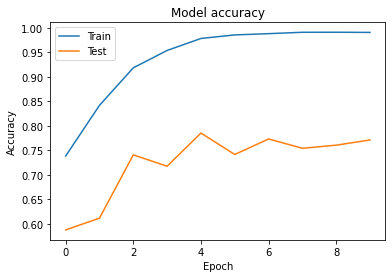

Maximum validation accuracy:  0.7853107452392578
Training accuracy of best model:  0.97842675


In [44]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
print(np.argmax(np.array(history.history['val_accuracy'])))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Maximum validation accuracy: ',np.max(np.array(history.history['val_accuracy'])))
print('Training accuracy of best model: ',np.array(history.history['accuracy'])[np.argmax(np.array(history.history['val_accuracy']))])



In [45]:
model = load_model(model_name)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
accuracy = accuracy_score(y_true, y_pred)


print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))


[[304 131]
 [141 751]]
the mean-f1 score: 0.77
accuracy is: 0.80


In [46]:
# Test data accuracy:
total_count, correct_count = get_prediction_accuracy(data_dir_test, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of test files:', total_count)
print('correctly predicted test files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
# Train accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_train, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of train files:', total_count)
print('correctly predicted train files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
#val accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_val, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of val files:', total_count)
print('correctly predicted val files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)

total_count of test files: 50
correctly predicted test files: 44
Percentage accuracy: 88.0
total_count of train files: 187
correctly predicted train files: 187
Percentage accuracy: 100.0
total_count of val files: 51
correctly predicted val files: 44
Percentage accuracy: 86.27450980392157


In [47]:
del train_x, train_y, train_files, val_x, val_y, val_files, test_x, test_y,test_files
del train_x2, train_y2, all_counts
del train_x3, train_y3

Wash

In [48]:
data_dir_train='data_micro/data_m_wash_TTV/train'
data_dir_val= 'data_micro/data_m_wash_TTV/val'
data_dir_test='data_micro/data_m_wash_TTV/test'
pos_lab = 'Wash'
neg_lab = 'No'
labelfile = 'LabelWash.csv'
model_name = "data_micro/DCBL_micro_Wash_jitter_mask.hdf5"

In [49]:
#receive windowed training and validation data
train_x, train_y, train_files = get_train_data(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
val_x, val_y, val_files = get_train_data(data_dir_val,sub_dirs,pos_lab,neg_lab,labelfile)
test_x, test_y, test_files = get_train_data(data_dir_test,sub_dirs,pos_lab,neg_lab,labelfile)
train_x2, train_y2, all_counts = get_train_data_2(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
train_x3, train_y3, all_counts = get_train_data_3(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)

In [50]:
train_samples_2 = np.array(train_x2) 
train_labels2_2 = np.array(train_y2)
print(train_samples_2.shape)
print(train_labels2_2.shape)
train_samples_3 = np.array(train_x3) 
train_labels2_3 = np.array(train_y3)
print(train_samples_3.shape)
print(train_labels2_3.shape)
train_samples = np.array(train_x) 
train_labels2 = np.array(train_y)
val_samples = np.array(val_x) 
val_labels2 = np.array(val_y)
test_samples = np.array(test_x) 
test_labels2 = np.array(test_y)
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)
train_samples = np.vstack((train_samples,train_samples_2, train_samples_3))
train_labels2 = np.hstack((train_labels2, train_labels2_2, train_labels2_3))

(5072, 12, 500)
(5072,)
(5063, 12, 500)
(5063,)
(5072, 12, 500)
(5072,)
(1411, 12, 500)
(1411,)
(1331, 12, 500)
(1331,)


In [51]:
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15207, 12, 500)
(15207,)
(1411, 12, 500)
(1411,)
(1331, 12, 500)
(1331,)


In [52]:
#convert to one hot encoding
from keras.utils  import to_categorical
train_labels = to_categorical(train_labels2)
train_labels.shape
val_labels = to_categorical(val_labels2)
val_labels.shape
test_labels = to_categorical(test_labels2)
test_labels.shape
print(train_samples.shape)
print(train_labels.shape)
print(val_samples.shape)
print(val_labels.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15207, 12, 500)
(15207, 2)
(1411, 12, 500)
(1411, 2)
(1331, 12, 500)
(1331,)


In [53]:
#For CNN and BidirLSTM:
number_of_samples = 500
train_samples = train_samples.reshape((-1, 12,number_of_samples, 1))
val_samples = val_samples.reshape((-1, 12,number_of_samples, 1))
test_samples = test_samples.reshape((-1, 12,number_of_samples, 1))
#For LSTM, uncomment these lines and comment above two lines
#train_samples = train_samples.reshape((-1, number_of_samples, 9))
#val_samples = val_samples.reshape((-1, number_of_samples, 9))

#9 refers to 9 accelerometer channels

In [54]:
batch_size = 64
num_feat_map = 128
num_hidden_lstm = 128
num_classes = 2

#Uncomment the classifier you are working with:
#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#for CNN/DCBL
_, dim, win_len,_ = train_samples.shape
#for LSTM uncomment the following line and comment above line
#_, dim, win_len = train_samples.shape

print(win_len)
print(dim)

500
12


In [55]:
p=0.5 #Dropout
b = 1 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
       
model_output(model)    
model.summary()

building the model ... 
ConvLSTM
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 12, 500, 128)      1408      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_9 (Batch (None, 12, 500, 128)      512       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_10 (Batc (None, 12, 500, 128)      512       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 166, 128)      0         
_________________________________________________________________
conv2d_16 (Conv2D)   

In [56]:
X_train = train_samples
y_train = train_labels
X_val = val_samples
y_val = val_labels
X_test = test_samples
y_test = test_labels

In [57]:
print(X_train.shape, X_val.shape, X_test.shape)

(15207, 12, 500, 1) (1411, 12, 500, 1) (1331, 12, 500, 1)


In [58]:
y_true = np.argmax(y_test, axis=1)

In [5]:
epochs = 10

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# checkpoint
filepath=model_name
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

checkpoint2 = monitor_Training()

callbacks_list = [checkpoint]

H = model.fit(train_samples, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_val, y_val),
             callbacks=callbacks_list
             )

In [60]:
history = H

2


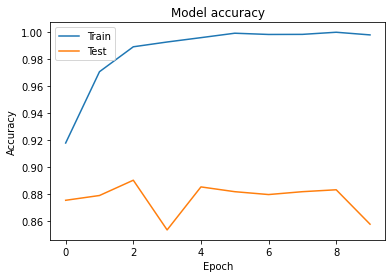

Maximum validation accuracy:  0.8901488184928894
Training accuracy of best model:  0.98908395


In [61]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
print(np.argmax(np.array(history.history['val_accuracy'])))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Maximum validation accuracy: ',np.max(np.array(history.history['val_accuracy'])))
print('Training accuracy of best model: ',np.array(history.history['accuracy'])[np.argmax(np.array(history.history['val_accuracy']))])


In [62]:
model = load_model(model_name)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
accuracy = accuracy_score(y_true, y_pred)


print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))


[[  96  136]
 [  38 1061]]
the mean-f1 score: 0.72
accuracy is: 0.87


In [63]:
# Test data accuracy:
total_count, correct_count = get_prediction_accuracy(data_dir_test, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of test files:', total_count)
print('correctly predicted test files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
# Train accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_train, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of train files:', total_count)
print('correctly predicted train files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
#val accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_val, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of val files:', total_count)
print('correctly predicted val files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)

total_count of test files: 50
correctly predicted test files: 44
Percentage accuracy: 88.0
total_count of train files: 188
correctly predicted train files: 188
Percentage accuracy: 100.0
total_count of val files: 50
correctly predicted val files: 46
Percentage accuracy: 92.0


In [64]:
del train_x, train_y, train_files, val_x, val_y, val_files, test_x, test_y,test_files
del train_x2, train_y2, all_counts
del train_x3, train_y3

Take

In [65]:
data_dir_train='data_micro/data_m_take_TTV/train'
data_dir_val= 'data_micro/data_m_take_TTV/val'
data_dir_test='data_micro/data_m_take_TTV/test'
pos_lab = 'Take'
neg_lab = 'No'
labelfile = 'LabelTake.csv'
model_name = "data_micro/DCBL_micro_Take_jitter_mask.hdf5"

In [66]:
#receive windowed training and validation data
train_x, train_y, train_files = get_train_data(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
val_x, val_y, val_files = get_train_data(data_dir_val,sub_dirs,pos_lab,neg_lab,labelfile)
test_x, test_y, test_files = get_train_data(data_dir_test,sub_dirs,pos_lab,neg_lab,labelfile)
train_x2, train_y2, all_counts = get_train_data_2(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
train_x3, train_y3, all_counts = get_train_data_3(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)

In [67]:
train_samples_2 = np.array(train_x2) 
train_labels2_2 = np.array(train_y2)
print(train_samples_2.shape)
print(train_labels2_2.shape)
train_samples_3 = np.array(train_x3) 
train_labels2_3 = np.array(train_y3)
print(train_samples_3.shape)
print(train_labels2_3.shape)
train_samples = np.array(train_x) 
train_labels2 = np.array(train_y)
val_samples = np.array(val_x) 
val_labels2 = np.array(val_y)
test_samples = np.array(test_x) 
test_labels2 = np.array(test_y)
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)
train_samples = np.vstack((train_samples,train_samples_2, train_samples_3))
train_labels2 = np.hstack((train_labels2, train_labels2_2, train_labels2_3))

(5096, 12, 500)
(5096,)
(5094, 12, 500)
(5094,)
(5096, 12, 500)
(5096,)
(1382, 12, 500)
(1382,)
(1336, 12, 500)
(1336,)


In [68]:
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15286, 12, 500)
(15286,)
(1382, 12, 500)
(1382,)
(1336, 12, 500)
(1336,)


In [69]:
#convert to one hot encoding
from keras.utils  import to_categorical
train_labels = to_categorical(train_labels2)
train_labels.shape
val_labels = to_categorical(val_labels2)
val_labels.shape
test_labels = to_categorical(test_labels2)
test_labels.shape
print(train_samples.shape)
print(train_labels.shape)
print(val_samples.shape)
print(val_labels.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15286, 12, 500)
(15286, 2)
(1382, 12, 500)
(1382, 2)
(1336, 12, 500)
(1336,)


In [70]:
#For CNN and BidirLSTM:
number_of_samples = 500
train_samples = train_samples.reshape((-1, 12,number_of_samples, 1))
val_samples = val_samples.reshape((-1, 12,number_of_samples, 1))
test_samples = test_samples.reshape((-1, 12,number_of_samples, 1))
#For LSTM, uncomment these lines and comment above two lines
#train_samples = train_samples.reshape((-1, number_of_samples, 9))
#val_samples = val_samples.reshape((-1, number_of_samples, 9))

#9 refers to 9 accelerometer channels

In [71]:
batch_size = 64
num_feat_map = 128
num_hidden_lstm = 128
num_classes = 2

#Uncomment the classifier you are working with:
#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#for CNN/DCBL
_, dim, win_len,_ = train_samples.shape
#for LSTM uncomment the following line and comment above line
#_, dim, win_len = train_samples.shape

print(win_len)
print(dim)

500
12


In [72]:
p=0.5 #Dropout
b = 1 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
       
model_output(model)    
model.summary()

building the model ... 
ConvLSTM
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 12, 500, 128)      1408      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_13 (Batc (None, 12, 500, 128)      512       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_14 (Batc (None, 12, 500, 128)      512       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 166, 128)      0         
_________________________________________________________________
conv2d_22 (Conv2D)   

In [73]:
X_train = train_samples
y_train = train_labels
X_val = val_samples
y_val = val_labels
X_test = test_samples
y_test = test_labels

In [74]:
print(X_train.shape, X_val.shape, X_test.shape)

(15286, 12, 500, 1) (1382, 12, 500, 1) (1336, 12, 500, 1)


In [75]:
y_true = np.argmax(y_test, axis=1)

In [6]:
epochs = 10

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# checkpoint
filepath=model_name
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

checkpoint2 = monitor_Training()

callbacks_list = [checkpoint]

H = model.fit(train_samples, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_val, y_val),
             callbacks=callbacks_list
             )

In [77]:
history = H

9


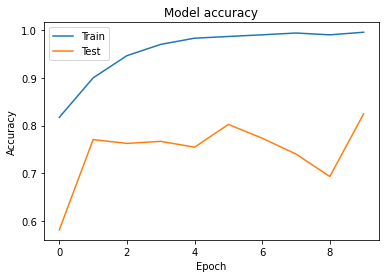

Maximum validation accuracy:  0.8248914480209351
Training accuracy of best model:  0.9960094


In [78]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
print(np.argmax(np.array(history.history['val_accuracy'])))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Maximum validation accuracy: ',np.max(np.array(history.history['val_accuracy'])))
print('Training accuracy of best model: ',np.array(history.history['accuracy'])[np.argmax(np.array(history.history['val_accuracy']))])



In [79]:
model = load_model(model_name)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
accuracy = accuracy_score(y_true, y_pred)


print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))


[[543  62]
 [140 591]]
the mean-f1 score: 0.84
accuracy is: 0.85


In [80]:
# Test data accuracy:
total_count, correct_count = get_prediction_accuracy(data_dir_test, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of test files:', total_count)
print('correctly predicted test files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
# Train accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_train, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of train files:', total_count)
print('correctly predicted train files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
#val accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_val, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of val files:', total_count)
print('correctly predicted val files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)

total_count of test files: 50
correctly predicted test files: 45
Percentage accuracy: 90.0
total_count of train files: 188
correctly predicted train files: 188
Percentage accuracy: 100.0
total_count of val files: 50
correctly predicted val files: 46
Percentage accuracy: 92.0


In [81]:
del train_x, train_y, train_files, val_x, val_y, val_files, test_x, test_y,test_files
del train_x2, train_y2, all_counts
del train_x3, train_y3

Put

In [82]:
data_dir_train='data_micro/data_m_put_TTV/train'
data_dir_val= 'data_micro/data_m_put_TTV/val'
data_dir_test='data_micro/data_m_put_TTV/test'
pos_lab = 'Put'
neg_lab = 'No'
labelfile = 'LabelPut.csv'
model_name = "data_micro/DCBL_micro_Put_jitter_mask.hdf5"

In [83]:
#receive windowed training and validation data
train_x, train_y, train_files = get_train_data(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
val_x, val_y, val_files = get_train_data(data_dir_val,sub_dirs,pos_lab,neg_lab,labelfile)
test_x, test_y, test_files = get_train_data(data_dir_test,sub_dirs,pos_lab,neg_lab,labelfile)
train_x2, train_y2, all_counts = get_train_data_2(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
train_x3, train_y3, all_counts = get_train_data_3(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)

In [84]:
train_samples_2 = np.array(train_x2) 
train_labels2_2 = np.array(train_y2)
print(train_samples_2.shape)
print(train_labels2_2.shape)
train_samples_3 = np.array(train_x3) 
train_labels2_3 = np.array(train_y3)
print(train_samples_3.shape)
print(train_labels2_3.shape)
train_samples = np.array(train_x) 
train_labels2 = np.array(train_y)
val_samples = np.array(val_x) 
val_labels2 = np.array(val_y)
test_samples = np.array(test_x) 
test_labels2 = np.array(test_y)
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)
train_samples = np.vstack((train_samples,train_samples_2, train_samples_3))
train_labels2 = np.hstack((train_labels2, train_labels2_2, train_labels2_3))

(5116, 12, 500)
(5116,)
(5117, 12, 500)
(5117,)
(5117, 12, 500)
(5117,)
(1344, 12, 500)
(1344,)
(1353, 12, 500)
(1353,)


In [85]:
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15350, 12, 500)
(15350,)
(1344, 12, 500)
(1344,)
(1353, 12, 500)
(1353,)


In [86]:
#convert to one hot encoding
from keras.utils  import to_categorical
train_labels = to_categorical(train_labels2)
train_labels.shape
val_labels = to_categorical(val_labels2)
val_labels.shape
test_labels = to_categorical(test_labels2)
test_labels.shape
print(train_samples.shape)
print(train_labels.shape)
print(val_samples.shape)
print(val_labels.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15350, 12, 500)
(15350, 2)
(1344, 12, 500)
(1344, 2)
(1353, 12, 500)
(1353,)


In [87]:
#For CNN and BidirLSTM:
number_of_samples = 500
train_samples = train_samples.reshape((-1, 12,number_of_samples, 1))
val_samples = val_samples.reshape((-1, 12,number_of_samples, 1))
test_samples = test_samples.reshape((-1, 12,number_of_samples, 1))
#For LSTM, uncomment these lines and comment above two lines
#train_samples = train_samples.reshape((-1, number_of_samples, 9))
#val_samples = val_samples.reshape((-1, number_of_samples, 9))

#9 refers to 9 accelerometer channels

In [88]:
batch_size = 64
num_feat_map = 128
num_hidden_lstm = 128
num_classes = 2

#Uncomment the classifier you are working with:
#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#for CNN/DCBL
_, dim, win_len,_ = train_samples.shape
#for LSTM uncomment the following line and comment above line
#_, dim, win_len = train_samples.shape

print(win_len)
print(dim)

500
12


In [89]:
p=0.5 #Dropout
b = 1 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
       
model_output(model)    
model.summary()

building the model ... 
ConvLSTM
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 12, 500, 128)      1408      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_17 (Batc (None, 12, 500, 128)      512       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_18 (Batc (None, 12, 500, 128)      512       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 166, 128)      0         
_________________________________________________________________
conv2d_28 (Conv2D)   

In [90]:
X_train = train_samples
y_train = train_labels
X_val = val_samples
y_val = val_labels
X_test = test_samples
y_test = test_labels

In [91]:
print(X_train.shape, X_val.shape, X_test.shape)

(15350, 12, 500, 1) (1344, 12, 500, 1) (1353, 12, 500, 1)


In [92]:
y_true = np.argmax(y_test, axis=1)

In [7]:
epochs = 10

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# checkpoint
filepath=model_name
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

#checkpoint2 = monitor_Training()

callbacks_list = [checkpoint]

H = model.fit(train_samples, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_val, y_val),
             callbacks=callbacks_list
             )

In [94]:
history = H

6


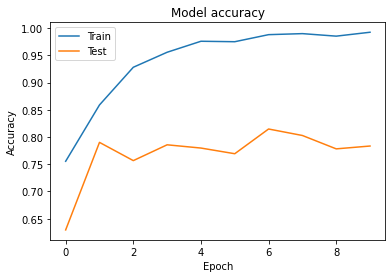

Maximum validation accuracy:  0.8147321343421936
Training accuracy of best model:  0.9879479


In [95]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
print(np.argmax(np.array(history.history['val_accuracy'])))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Maximum validation accuracy: ',np.max(np.array(history.history['val_accuracy'])))
print('Training accuracy of best model: ',np.array(history.history['accuracy'])[np.argmax(np.array(history.history['val_accuracy']))])



In [96]:
model = load_model(model_name)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
accuracy = accuracy_score(y_true, y_pred)


print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))


[[341 113]
 [109 790]]
the mean-f1 score: 0.81
accuracy is: 0.84


In [97]:
# Test data accuracy:
total_count, correct_count = get_prediction_accuracy(data_dir_test, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of test files:', total_count)
print('correctly predicted test files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
# Train accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_train, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of train files:', total_count)
print('correctly predicted train files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
#val accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_val, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of val files:', total_count)
print('correctly predicted val files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)

total_count of test files: 50
correctly predicted test files: 43
Percentage accuracy: 86.0
total_count of train files: 189
correctly predicted train files: 186
Percentage accuracy: 98.4126984126984
total_count of val files: 49
correctly predicted val files: 45
Percentage accuracy: 91.83673469387756


In [98]:
del train_x, train_y, train_files, val_x, val_y, val_files, test_x, test_y,test_files
del train_x2, train_y2, all_counts
del train_x3, train_y3

Peel

In [99]:
data_dir_train='data_micro/data_m_peel_TTV/train'
data_dir_val= 'data_micro/data_m_peel_TTV/val'
data_dir_test='data_micro/data_m_peel_TTV/test'
pos_lab = 'Peel'
neg_lab = 'No'
labelfile = 'LabelPeel.csv'
model_name = "data_micro/DCBL_micro_Peel_jitter_mask.hdf5"

In [100]:
#receive windowed training and validation data
train_x, train_y, train_files = get_train_data(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
val_x, val_y, val_files = get_train_data(data_dir_val,sub_dirs,pos_lab,neg_lab,labelfile)
test_x, test_y, test_files = get_train_data(data_dir_test,sub_dirs,pos_lab,neg_lab,labelfile)
train_x2, train_y2, all_counts = get_train_data_2(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
train_x3, train_y3, all_counts = get_train_data_3(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)

In [101]:
train_samples_2 = np.array(train_x2) 
train_labels2_2 = np.array(train_y2)
print(train_samples_2.shape)
print(train_labels2_2.shape)
train_samples_3 = np.array(train_x3) 
train_labels2_3 = np.array(train_y3)
print(train_samples_3.shape)
print(train_labels2_3.shape)
train_samples = np.array(train_x) 
train_labels2 = np.array(train_y)
val_samples = np.array(val_x) 
val_labels2 = np.array(val_y)
test_samples = np.array(test_x) 
test_labels2 = np.array(test_y)
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)
train_samples = np.vstack((train_samples,train_samples_2, train_samples_3))
train_labels2 = np.hstack((train_labels2, train_labels2_2, train_labels2_3))

(5163, 12, 500)
(5163,)
(5159, 12, 500)
(5159,)
(5163, 12, 500)
(5163,)
(1280, 12, 500)
(1280,)
(1371, 12, 500)
(1371,)


In [102]:
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15485, 12, 500)
(15485,)
(1280, 12, 500)
(1280,)
(1371, 12, 500)
(1371,)


In [103]:
#convert to one hot encoding
from keras.utils  import to_categorical
train_labels = to_categorical(train_labels2)
train_labels.shape
val_labels = to_categorical(val_labels2)
val_labels.shape
test_labels = to_categorical(test_labels2)
test_labels.shape
print(train_samples.shape)
print(train_labels.shape)
print(val_samples.shape)
print(val_labels.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15485, 12, 500)
(15485, 2)
(1280, 12, 500)
(1280, 2)
(1371, 12, 500)
(1371,)


In [104]:
#For CNN and BidirLSTM:
number_of_samples = 500
train_samples = train_samples.reshape((-1, 12,number_of_samples, 1))
val_samples = val_samples.reshape((-1, 12,number_of_samples, 1))
test_samples = test_samples.reshape((-1, 12,number_of_samples, 1))
#For LSTM, uncomment these lines and comment above two lines
#train_samples = train_samples.reshape((-1, number_of_samples, 9))
#val_samples = val_samples.reshape((-1, number_of_samples, 9))

#9 refers to 9 accelerometer channels

In [105]:
batch_size = 64
num_feat_map = 128
num_hidden_lstm = 128
num_classes = 2

#Uncomment the classifier you are working with:
#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#for CNN/DCBL
_, dim, win_len,_ = train_samples.shape
#for LSTM uncomment the following line and comment above line
#_, dim, win_len = train_samples.shape

print(win_len)
print(dim)

500
12


In [106]:
p=0.5 #Dropout
b = 1 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
       
model_output(model)    
model.summary()

building the model ... 
ConvLSTM
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 12, 500, 128)      1408      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_21 (Batc (None, 12, 500, 128)      512       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_22 (Batc (None, 12, 500, 128)      512       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 166, 128)      0         
_________________________________________________________________
conv2d_34 (Conv2D)   

In [107]:
X_train = train_samples
y_train = train_labels
X_val = val_samples
y_val = val_labels
X_test = test_samples
y_test = test_labels

In [108]:
print(X_train.shape, X_val.shape, X_test.shape)

(15485, 12, 500, 1) (1280, 12, 500, 1) (1371, 12, 500, 1)


In [109]:
y_true = np.argmax(y_test, axis=1)

In [8]:
epochs = 10

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# checkpoint
filepath=model_name
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

#checkpoint2 = monitor_Training()

callbacks_list = [checkpoint]

H = model.fit(train_samples, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_val, y_val),
             callbacks=callbacks_list
             )

In [112]:
history = H

9


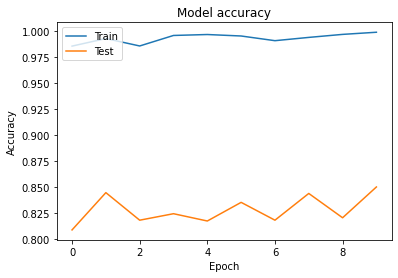

Maximum validation accuracy:  0.8500000238418579
Training accuracy of best model:  0.99916047


In [113]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
print(np.argmax(np.array(history.history['val_accuracy'])))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Maximum validation accuracy: ',np.max(np.array(history.history['val_accuracy'])))
print('Training accuracy of best model: ',np.array(history.history['accuracy'])[np.argmax(np.array(history.history['val_accuracy']))])



In [114]:
model = load_model(model_name)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
accuracy = accuracy_score(y_true, y_pred)


print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))


[[374  32]
 [113 852]]
the mean-f1 score: 0.88
accuracy is: 0.89


In [115]:
# Test data accuracy:
total_count, correct_count = get_prediction_accuracy(data_dir_test, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of test files:', total_count)
print('correctly predicted test files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
# Train accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_train, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of train files:', total_count)
print('correctly predicted train files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
#val accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_val, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of val files:', total_count)
print('correctly predicted val files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)

total_count of test files: 50
correctly predicted test files: 49
Percentage accuracy: 98.0
total_count of train files: 188
correctly predicted train files: 188
Percentage accuracy: 100.0
total_count of val files: 50
correctly predicted val files: 46
Percentage accuracy: 92.0


In [116]:
del train_x, train_y, train_files, val_x, val_y, val_files, test_x, test_y,test_files
del train_x2, train_y2, all_counts
del train_x3, train_y3

Mix

In [117]:
data_dir_train='data_micro/data_m_mix_TTV/train'
data_dir_val= 'data_micro/data_m_mix_TTV/val'
data_dir_test='data_micro/data_m_mix_TTV/test'
pos_lab = 'Mix'
neg_lab = 'No'
labelfile = 'LabelMix.csv'
model_name = "data_micro/DCBL_micro_Mix_jitter_mask.hdf5"

In [118]:
#receive windowed training and validation data
train_x, train_y, train_files = get_train_data(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
val_x, val_y, val_files = get_train_data(data_dir_val,sub_dirs,pos_lab,neg_lab,labelfile)
test_x, test_y, test_files = get_train_data(data_dir_test,sub_dirs,pos_lab,neg_lab,labelfile)
train_x2, train_y2, all_counts = get_train_data_2(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
train_x3, train_y3, all_counts = get_train_data_3(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)

In [119]:
train_samples_2 = np.array(train_x2) 
train_labels2_2 = np.array(train_y2)
print(train_samples_2.shape)
print(train_labels2_2.shape)
train_samples_3 = np.array(train_x3) 
train_labels2_3 = np.array(train_y3)
print(train_samples_3.shape)
print(train_labels2_3.shape)
train_samples = np.array(train_x) 
train_labels2 = np.array(train_y)
val_samples = np.array(val_x) 
val_labels2 = np.array(val_y)
test_samples = np.array(test_x) 
test_labels2 = np.array(test_y)
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)
train_samples = np.vstack((train_samples,train_samples_2, train_samples_3))
train_labels2 = np.hstack((train_labels2, train_labels2_2, train_labels2_3))

(5044, 12, 500)
(5044,)
(5035, 12, 500)
(5035,)
(5044, 12, 500)
(5044,)
(1407, 12, 500)
(1407,)
(1363, 12, 500)
(1363,)


In [120]:
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15123, 12, 500)
(15123,)
(1407, 12, 500)
(1407,)
(1363, 12, 500)
(1363,)


In [121]:
#convert to one hot encoding
from keras.utils  import to_categorical
train_labels = to_categorical(train_labels2)
train_labels.shape
val_labels = to_categorical(val_labels2)
val_labels.shape
test_labels = to_categorical(test_labels2)
test_labels.shape
print(train_samples.shape)
print(train_labels.shape)
print(val_samples.shape)
print(val_labels.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15123, 12, 500)
(15123, 2)
(1407, 12, 500)
(1407, 2)
(1363, 12, 500)
(1363,)


In [122]:
#For CNN and BidirLSTM:
number_of_samples = 500
train_samples = train_samples.reshape((-1, 12,number_of_samples, 1))
val_samples = val_samples.reshape((-1, 12,number_of_samples, 1))
test_samples = test_samples.reshape((-1, 12,number_of_samples, 1))
#For LSTM, uncomment these lines and comment above two lines
#train_samples = train_samples.reshape((-1, number_of_samples, 9))
#val_samples = val_samples.reshape((-1, number_of_samples, 9))

#9 refers to 9 accelerometer channels

In [123]:
batch_size = 64
num_feat_map = 128
num_hidden_lstm = 128
num_classes = 2

#Uncomment the classifier you are working with:
#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#for CNN/DCBL
_, dim, win_len,_ = train_samples.shape
#for LSTM uncomment the following line and comment above line
#_, dim, win_len = train_samples.shape

print(win_len)
print(dim)

500
12


In [124]:
p=0.5 #Dropout
b = 1 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
       
model_output(model)    
model.summary()

building the model ... 
ConvLSTM
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 12, 500, 128)      1408      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_25 (Batc (None, 12, 500, 128)      512       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_26 (Batc (None, 12, 500, 128)      512       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 12, 166, 128)      0         
_________________________________________________________________
conv2d_40 (Conv2D)   

In [125]:
X_train = train_samples
y_train = train_labels
X_val = val_samples
y_val = val_labels
X_test = test_samples
y_test = test_labels

In [126]:
print(X_train.shape, X_val.shape, X_test.shape)

(15123, 12, 500, 1) (1407, 12, 500, 1) (1363, 12, 500, 1)


In [127]:
y_true = np.argmax(y_test, axis=1)

In [9]:
epochs = 10

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# checkpoint
filepath=model_name
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

#checkpoint2 = monitor_Training()

callbacks_list = [checkpoint]

H = model.fit(train_samples, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_val, y_val),
             callbacks=callbacks_list
             )

In [130]:
history = H

6


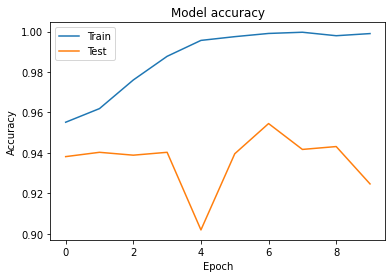

Maximum validation accuracy:  0.9545131325721741
Training accuracy of best model:  0.9990743


In [131]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
print(np.argmax(np.array(history.history['val_accuracy'])))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Maximum validation accuracy: ',np.max(np.array(history.history['val_accuracy'])))
print('Training accuracy of best model: ',np.array(history.history['accuracy'])[np.argmax(np.array(history.history['val_accuracy']))])



In [132]:
model = load_model(model_name)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
accuracy = accuracy_score(y_true, y_pred)


print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))


[[  40   63]
 [  14 1246]]
the mean-f1 score: 0.74
accuracy is: 0.94


In [133]:
# Test data accuracy:
total_count, correct_count = get_prediction_accuracy(data_dir_test, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of test files:', total_count)
print('correctly predicted test files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
# Train accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_train, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of train files:', total_count)
print('correctly predicted train files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
#val accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_val, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of val files:', total_count)
print('correctly predicted val files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)

total_count of test files: 50
correctly predicted test files: 47
Percentage accuracy: 94.0
total_count of train files: 187
correctly predicted train files: 187
Percentage accuracy: 100.0
total_count of val files: 51
correctly predicted val files: 49
Percentage accuracy: 96.07843137254902


In [134]:
del train_x, train_y, train_files, val_x, val_y, val_files, test_x, test_y,test_files
del train_x2, train_y2, all_counts
del train_x3, train_y3

Pour

In [135]:
data_dir_train='data_micro/data_m_pour_TTV/train'
data_dir_val= 'data_micro/data_m_pour_TTV/val'
data_dir_test='data_micro/data_m_pour_TTV/test'
pos_lab = 'Pour'
neg_lab = 'No'
labelfile = 'LabelPour.csv'
model_name = "data_micro/DCBL_micro_Pour_jitter_mask.hdf5"

In [136]:
#receive windowed training and validation data
train_x, train_y, train_files = get_train_data(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
val_x, val_y, val_files = get_train_data(data_dir_val,sub_dirs,pos_lab,neg_lab,labelfile)
test_x, test_y, test_files = get_train_data(data_dir_test,sub_dirs,pos_lab,neg_lab,labelfile)
train_x2, train_y2, all_counts = get_train_data_2(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
train_x3, train_y3, all_counts = get_train_data_3(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)

In [137]:
train_samples_2 = np.array(train_x2) 
train_labels2_2 = np.array(train_y2)
print(train_samples_2.shape)
print(train_labels2_2.shape)
train_samples_3 = np.array(train_x3) 
train_labels2_3 = np.array(train_y3)
print(train_samples_3.shape)
print(train_labels2_3.shape)
train_samples = np.array(train_x) 
train_labels2 = np.array(train_y)
val_samples = np.array(val_x) 
val_labels2 = np.array(val_y)
test_samples = np.array(test_x) 
test_labels2 = np.array(test_y)
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)
train_samples = np.vstack((train_samples,train_samples_2, train_samples_3))
train_labels2 = np.hstack((train_labels2, train_labels2_2, train_labels2_3))

(5205, 12, 500)
(5205,)
(5193, 12, 500)
(5193,)
(5205, 12, 500)
(5205,)
(1274, 12, 500)
(1274,)
(1335, 12, 500)
(1335,)


In [138]:
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15603, 12, 500)
(15603,)
(1274, 12, 500)
(1274,)
(1335, 12, 500)
(1335,)


In [139]:
#convert to one hot encoding
from keras.utils  import to_categorical
train_labels = to_categorical(train_labels2)
train_labels.shape
val_labels = to_categorical(val_labels2)
val_labels.shape
test_labels = to_categorical(test_labels2)
test_labels.shape
print(train_samples.shape)
print(train_labels.shape)
print(val_samples.shape)
print(val_labels.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15603, 12, 500)
(15603, 2)
(1274, 12, 500)
(1274, 2)
(1335, 12, 500)
(1335,)


In [140]:
#For CNN and BidirLSTM:
number_of_samples = 500
train_samples = train_samples.reshape((-1, 12,number_of_samples, 1))
val_samples = val_samples.reshape((-1, 12,number_of_samples, 1))
test_samples = test_samples.reshape((-1, 12,number_of_samples, 1))
#For LSTM, uncomment these lines and comment above two lines
#train_samples = train_samples.reshape((-1, number_of_samples, 9))
#val_samples = val_samples.reshape((-1, number_of_samples, 9))

#9 refers to 9 accelerometer channels

In [141]:
batch_size = 64
num_feat_map = 128
num_hidden_lstm = 128
num_classes = 2

#Uncomment the classifier you are working with:
#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#for CNN/DCBL
_, dim, win_len,_ = train_samples.shape
#for LSTM uncomment the following line and comment above line
#_, dim, win_len = train_samples.shape

print(win_len)
print(dim)

500
12


In [142]:
p=0.5 #Dropout
b = 1 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
       
model_output(model)    
model.summary()

building the model ... 
ConvLSTM
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 12, 500, 128)      1408      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_29 (Batc (None, 12, 500, 128)      512       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_30 (Batc (None, 12, 500, 128)      512       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 166, 128)      0         
_________________________________________________________________
conv2d_46 (Conv2D)   

In [143]:
X_train = train_samples
y_train = train_labels
X_val = val_samples
y_val = val_labels
X_test = test_samples
y_test = test_labels

In [144]:
print(X_train.shape, X_val.shape, X_test.shape)

(15603, 12, 500, 1) (1274, 12, 500, 1) (1335, 12, 500, 1)


In [145]:
y_true = np.argmax(y_test, axis=1)

In [10]:
epochs = 10

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# checkpoint
filepath=model_name
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

#checkpoint2 = monitor_Training()

callbacks_list = [checkpoint]

H = model.fit(train_samples, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_val, y_val),
             callbacks=callbacks_list
             )

In [147]:
history = H

8


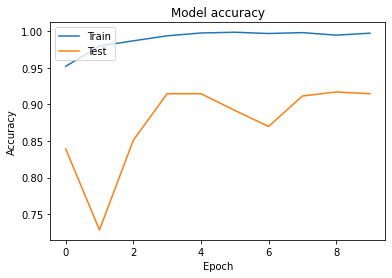

Maximum validation accuracy:  0.9167974591255188
Training accuracy of best model:  0.99442416


In [148]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
print(np.argmax(np.array(history.history['val_accuracy'])))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Maximum validation accuracy: ',np.max(np.array(history.history['val_accuracy'])))
print('Training accuracy of best model: ',np.array(history.history['accuracy'])[np.argmax(np.array(history.history['val_accuracy']))])



In [149]:
model = load_model(model_name)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
accuracy = accuracy_score(y_true, y_pred)


print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))


[[  30  117]
 [   8 1180]]
the mean-f1 score: 0.64
accuracy is: 0.91


In [150]:
# Test data accuracy:
total_count, correct_count = get_prediction_accuracy(data_dir_test, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of test files:', total_count)
print('correctly predicted test files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
# Train accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_train, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of train files:', total_count)
print('correctly predicted train files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
#val accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_val, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of val files:', total_count)
print('correctly predicted val files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)

total_count of test files: 50
correctly predicted test files: 45
Percentage accuracy: 90.0
total_count of train files: 188
correctly predicted train files: 185
Percentage accuracy: 98.40425531914893
total_count of val files: 50
correctly predicted val files: 46
Percentage accuracy: 92.0


In [151]:
del train_x, train_y, train_files, val_x, val_y, val_files, test_x, test_y,test_files
del train_x2, train_y2, all_counts
del train_x3, train_y3

Open

In [152]:
data_dir_train='data_micro/data_m_open_TTV/train'
data_dir_val= 'data_micro/data_m_open_TTV/val'
data_dir_test='data_micro/data_m_open_TTV/test'
pos_lab = 'Open'
neg_lab = 'No'
labelfile = 'LabelOpen.csv'
model_name = "data_micro/DCBL_micro_Open_jitter_mask.hdf5"

In [153]:
#receive windowed training and validation data
train_x, train_y, train_files = get_train_data(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
val_x, val_y, val_files = get_train_data(data_dir_val,sub_dirs,pos_lab,neg_lab,labelfile)
test_x, test_y, test_files = get_train_data(data_dir_test,sub_dirs,pos_lab,neg_lab,labelfile)
train_x2, train_y2, all_counts = get_train_data_2(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
train_x3, train_y3, all_counts = get_train_data_3(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)

In [154]:
train_samples_2 = np.array(train_x2) 
train_labels2_2 = np.array(train_y2)
print(train_samples_2.shape)
print(train_labels2_2.shape)
train_samples_3 = np.array(train_x3) 
train_labels2_3 = np.array(train_y3)
print(train_samples_3.shape)
print(train_labels2_3.shape)
train_samples = np.array(train_x) 
train_labels2 = np.array(train_y)
val_samples = np.array(val_x) 
val_labels2 = np.array(val_y)
test_samples = np.array(test_x) 
test_labels2 = np.array(test_y)
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)
train_samples = np.vstack((train_samples,train_samples_2, train_samples_3))
train_labels2 = np.hstack((train_labels2, train_labels2_2, train_labels2_3))

(5045, 12, 500)
(5045,)
(5040, 12, 500)
(5040,)
(5046, 12, 500)
(5046,)
(1428, 12, 500)
(1428,)
(1340, 12, 500)
(1340,)


In [155]:
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15131, 12, 500)
(15131,)
(1428, 12, 500)
(1428,)
(1340, 12, 500)
(1340,)


In [156]:
#convert to one hot encoding
from keras.utils  import to_categorical
train_labels = to_categorical(train_labels2)
train_labels.shape
val_labels = to_categorical(val_labels2)
val_labels.shape
test_labels = to_categorical(test_labels2)
test_labels.shape
print(train_samples.shape)
print(train_labels.shape)
print(val_samples.shape)
print(val_labels.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15131, 12, 500)
(15131, 2)
(1428, 12, 500)
(1428, 2)
(1340, 12, 500)
(1340,)


In [157]:
#For CNN and BidirLSTM:
number_of_samples = 500
train_samples = train_samples.reshape((-1, 12,number_of_samples, 1))
val_samples = val_samples.reshape((-1, 12,number_of_samples, 1))
test_samples = test_samples.reshape((-1, 12,number_of_samples, 1))
#For LSTM, uncomment these lines and comment above two lines
#train_samples = train_samples.reshape((-1, number_of_samples, 9))
#val_samples = val_samples.reshape((-1, number_of_samples, 9))

#9 refers to 9 accelerometer channels

In [158]:
batch_size = 64
num_feat_map = 128
num_hidden_lstm = 128
num_classes = 2

#Uncomment the classifier you are working with:
#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#for CNN/DCBL
_, dim, win_len,_ = train_samples.shape
#for LSTM uncomment the following line and comment above line
#_, dim, win_len = train_samples.shape

print(win_len)
print(dim)

500
12


In [159]:
p=0.5 #Dropout
b = 1 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
       
model_output(model)    
model.summary()

building the model ... 
ConvLSTM
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 12, 500, 128)      1408      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_33 (Batc (None, 12, 500, 128)      512       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_34 (Batc (None, 12, 500, 128)      512       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 12, 166, 128)      0         
_________________________________________________________________
conv2d_52 (Conv2D)   

In [160]:
X_train = train_samples
y_train = train_labels
X_val = val_samples
y_val = val_labels
X_test = test_samples
y_test = test_labels

In [161]:
print(X_train.shape, X_val.shape, X_test.shape)

(15131, 12, 500, 1) (1428, 12, 500, 1) (1340, 12, 500, 1)


In [162]:
y_true = np.argmax(y_test, axis=1)

In [11]:
epochs = 10

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# checkpoint
filepath=model_name
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

#checkpoint2 = monitor_Training()

callbacks_list = [checkpoint]

H = model.fit(train_samples, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_val, y_val),
             callbacks=callbacks_list
             )

In [164]:
history = H

6


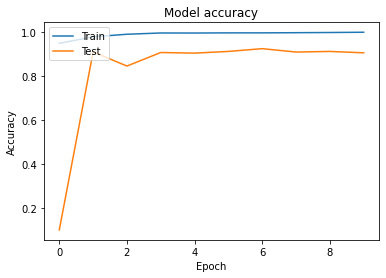

Maximum validation accuracy:  0.92507004737854
Training accuracy of best model:  0.99702597


In [166]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
print(np.argmax(np.array(history.history['val_accuracy'])))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Maximum validation accuracy: ',np.max(np.array(history.history['val_accuracy'])))
print('Training accuracy of best model: ',np.array(history.history['accuracy'])[np.argmax(np.array(history.history['val_accuracy']))])



In [167]:
model = load_model(model_name)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
accuracy = accuracy_score(y_true, y_pred)


print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))


[[  56   60]
 [  21 1203]]
the mean-f1 score: 0.77
accuracy is: 0.94


In [168]:
# Test data accuracy:
total_count, correct_count = get_prediction_accuracy(data_dir_test, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of test files:', total_count)
print('correctly predicted test files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
# Train accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_train, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of train files:', total_count)
print('correctly predicted train files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
#val accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_val, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of val files:', total_count)
print('correctly predicted val files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)

total_count of test files: 50
correctly predicted test files: 47
Percentage accuracy: 94.0
total_count of train files: 187
correctly predicted train files: 187
Percentage accuracy: 100.0
total_count of val files: 51
correctly predicted val files: 47
Percentage accuracy: 92.15686274509804


In [169]:
del train_x, train_y, train_files, val_x, val_y, val_files, test_x, test_y,test_files
del train_x2, train_y2, all_counts
del train_x3, train_y3

other

In [170]:
data_dir_train='data_micro/data_m_other_TTV/train'
data_dir_val= 'data_micro/data_m_other_TTV/val'
data_dir_test='data_micro/data_m_other_TTV/test'
pos_lab = 'other'
neg_lab = 'No'
labelfile = 'Labelother.csv'
model_name = "data_micro/DCBL_micro_other_jitter_mask.hdf5"

In [171]:
#receive windowed training and validation data
train_x, train_y, train_files = get_train_data(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
val_x, val_y, val_files = get_train_data(data_dir_val,sub_dirs,pos_lab,neg_lab,labelfile)
test_x, test_y, test_files = get_train_data(data_dir_test,sub_dirs,pos_lab,neg_lab,labelfile)
train_x2, train_y2, all_counts = get_train_data_2(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)
train_x3, train_y3, all_counts = get_train_data_3(data_dir_train,sub_dirs,pos_lab,neg_lab,labelfile)

In [172]:
train_samples_2 = np.array(train_x2) 
train_labels2_2 = np.array(train_y2)
print(train_samples_2.shape)
print(train_labels2_2.shape)
train_samples_3 = np.array(train_x3) 
train_labels2_3 = np.array(train_y3)
print(train_samples_3.shape)
print(train_labels2_3.shape)
train_samples = np.array(train_x) 
train_labels2 = np.array(train_y)
val_samples = np.array(val_x) 
val_labels2 = np.array(val_y)
test_samples = np.array(test_x) 
test_labels2 = np.array(test_y)
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)
train_samples = np.vstack((train_samples,train_samples_2, train_samples_3))
train_labels2 = np.hstack((train_labels2, train_labels2_2, train_labels2_3))

(5105, 12, 500)
(5105,)
(5099, 12, 500)
(5099,)
(5107, 12, 500)
(5107,)
(1373, 12, 500)
(1373,)
(1334, 12, 500)
(1334,)


In [173]:
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15311, 12, 500)
(15311,)
(1373, 12, 500)
(1373,)
(1334, 12, 500)
(1334,)


In [174]:
#convert to one hot encoding
from keras.utils  import to_categorical
train_labels = to_categorical(train_labels2)
train_labels.shape
val_labels = to_categorical(val_labels2)
val_labels.shape
test_labels = to_categorical(test_labels2)
test_labels.shape
print(train_samples.shape)
print(train_labels.shape)
print(val_samples.shape)
print(val_labels.shape)
print(test_samples.shape)
print(test_labels2.shape)

(15311, 12, 500)
(15311, 2)
(1373, 12, 500)
(1373, 2)
(1334, 12, 500)
(1334,)


In [175]:
#For CNN and BidirLSTM:
number_of_samples = 500
train_samples = train_samples.reshape((-1, 12,number_of_samples, 1))
val_samples = val_samples.reshape((-1, 12,number_of_samples, 1))
test_samples = test_samples.reshape((-1, 12,number_of_samples, 1))
#For LSTM, uncomment these lines and comment above two lines
#train_samples = train_samples.reshape((-1, number_of_samples, 9))
#val_samples = val_samples.reshape((-1, number_of_samples, 9))

#9 refers to 9 accelerometer channels

In [176]:
batch_size = 64
num_feat_map = 128
num_hidden_lstm = 128
num_classes = 2

#Uncomment the classifier you are working with:
#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#for CNN/DCBL
_, dim, win_len,_ = train_samples.shape
#for LSTM uncomment the following line and comment above line
#_, dim, win_len = train_samples.shape

print(win_len)
print(dim)

500
12


In [185]:
p=0.5 #Dropout
b = 1 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
       
model_output(model)    
model.summary()

building the model ... 
ConvLSTM
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 12, 500, 128)      1408      
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_41 (Batc (None, 12, 500, 128)      512       
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_42 (Batc (None, 12, 500, 128)      512       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 12, 166, 128)      0         
_________________________________________________________________
conv2d_64 (Conv2D)  

In [186]:
X_train = train_samples
y_train = train_labels
X_val = val_samples
y_val = val_labels
X_test = test_samples
y_test = test_labels

In [187]:
print(X_train.shape, X_val.shape, X_test.shape)

(15311, 12, 500, 1) (1373, 12, 500, 1) (1334, 12, 500, 1)


In [188]:
y_true = np.argmax(y_test, axis=1)

In [12]:
epochs = 10

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# checkpoint
filepath=model_name
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

#checkpoint2 = monitor_Training()

callbacks_list = [checkpoint]

H = model.fit(train_samples, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_val, y_val),
             callbacks=callbacks_list
             )

In [190]:
history = H

7


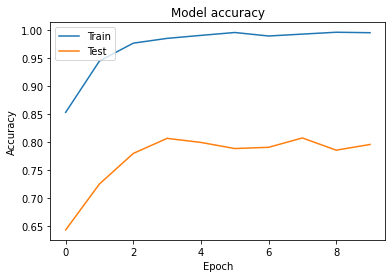

Maximum validation accuracy:  0.8069919943809509
Training accuracy of best model:  0.99288094


In [191]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
print(np.argmax(np.array(history.history['val_accuracy'])))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Maximum validation accuracy: ',np.max(np.array(history.history['val_accuracy'])))
print('Training accuracy of best model: ',np.array(history.history['accuracy'])[np.argmax(np.array(history.history['val_accuracy']))])



In [192]:
model = load_model(model_name)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
accuracy = accuracy_score(y_true, y_pred)


print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))


[[212 136]
 [ 45 941]]
the mean-f1 score: 0.81
accuracy is: 0.86


In [193]:
# Test data accuracy:
total_count, correct_count = get_prediction_accuracy(data_dir_test, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of test files:', total_count)
print('correctly predicted test files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
# Train accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_train, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of train files:', total_count)
print('correctly predicted train files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)
#val accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_val, sub_dirs,pos_lab,neg_lab,labelfile,model)
print('total_count of val files:', total_count)
print('correctly predicted val files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)

total_count of test files: 50
correctly predicted test files: 44
Percentage accuracy: 88.0
total_count of train files: 188
correctly predicted train files: 187
Percentage accuracy: 99.46808510638297
total_count of val files: 50
correctly predicted val files: 41
Percentage accuracy: 82.0


In [194]:
del train_x, train_y, train_files, val_x, val_y, val_files, test_x, test_y,test_files
del train_x2, train_y2, all_counts
del train_x3, train_y3

In [12]:
data_dir_test='test_micro_ov/'
labelfile = 'data/LabelTable.csv'

In [13]:
modelcut = load_model('data_micro/DCBL_micro_Cut_jitter_mask.hdf5')
modelwash = load_model('data_micro/DCBL_micro_Wash_jitter_mask.hdf5')
modeltake = load_model('data_micro/DCBL_micro_Take_jitter_mask.hdf5')
modelput = load_model('data_micro/DCBL_micro_Put_jitter_mask.hdf5')
modelpeel = load_model('data_micro/DCBL_micro_Peel_jitter_mask.hdf5')
modeladd = load_model('data_micro/DCBL_micro_ADD_jitter_mask.hdf5')
modelmix = load_model('data_micro/DCBL_micro_Mix_jitter_mask.hdf5')
modelpour = load_model('data_micro/DCBL_micro_Pour_jitter_mask.hdf5')
modelopen = load_model('data_micro/DCBL_micro_Open_jitter_mask.hdf5')
modelother = load_model('data_micro/DCBL_micro_other_jitter_mask.hdf5')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [14]:
def get_test_prediction_accuracy(data_dir, sub_dirs,labelfile,modelcut,modelwash,modeltake,modelput,modelpeel,modeladd,modelmix,modelpour,modelopen,modelother):

    files = os.listdir(data_dir+'/left_hip')
    number_of_samples = 500

    labels_micro =dict()
    
    labels_micro['Cut'] = 0
    labels_micro['Wash'] = 1
    labels_micro['Take'] = 2
    labels_micro['Put'] = 3
    labels_micro['Peel'] = 4
    labels_micro['Add'] = 5
    labels_micro['Mix'] = 6
    labels_micro['Pour'] = 7
    labels_micro['Open'] = 8
    labels_micro['other'] = 9 
    
    
    #read the labels
    labels_loc = labelfile
    file_label = open(labels_loc, newline='')
    label_reader = csv.reader(file_label)
    file_label_mapping = dict()
    
    for row in label_reader:
        label = row[2].split(',')
        
        label_file_micro = [0]*10
        for lab in label:
            if lab!='' and lab !='micro':
                label_file_micro[labels_micro[lab]] = 1
                
        
        file_label_mapping[row[0]+'.csv'] = label_file_micro


    total_count = 0
    correct_count = 0

    for f in files:

        file_data = []
        file_label = []

        st_index = 0
        end_index = 30000
        step = 1000 #overlapping window, step: 1000. 
        window_index = 10000 #6 second window

        print('reading file:',f)
        f_name = f

        if f_name == '.DS_Store':
            continue

        total_count = total_count+1

        curr_label_file = file_label_mapping[f_name]

        while st_index+step < end_index:

            data, data_mask, data_count = parse_IMU_files(data_dir, sub_dirs, st_index, st_index+window_index,  f, number_of_samples)
            st_index = st_index+step

            if data_count<data_min_count:
                continue

            train_data_sample  = np.zeros((12, number_of_samples))
            train_data_label   = curr_label_file
            for i in range(len(data)):
                for j in range(len(data[i])):
                    train_data_sample[i*4,j]=data[i][j][0]
                    train_data_sample[i*4+1,j]=data[i][j][1]
                    train_data_sample[i*4+2,j]=data[i][j][2]
                    
                    #mask information
                    train_data_sample[i*4+3,j]=data_mask[i][j]
                    
            file_data.append(train_data_sample)
            #file_label.append(train_data_label)

        file_data = np.array(file_data)
        file_label = curr_label_file

        file_data = file_data.reshape((-1,12,500, 1))

        #y_pred = np.argmax(model.predict(file_data), axis=1) 
        
        y_pred_cut = modelcut.predict(file_data)
     
        y_pred_wash = modelwash.predict(file_data)

        y_pred_take = modeltake.predict(file_data)

        y_pred_put = modelput.predict(file_data)

        y_pred_peel = modelpeel.predict(file_data)
  
        y_pred_add = modeladd.predict(file_data)
 
        y_pred_mix = modelmix.predict(file_data)
    
        y_pred_pour = modelpour.predict(file_data)
  
        y_pred_open = modelopen.predict(file_data)
    
        y_pred_other = modelother.predict(file_data)


        
        y_pred = np.zeros((file_data.shape[0],10))
        
        for j in range(0,y_pred.shape[0]):
            if(y_pred_cut[j,0]>=y_pred_cut[j,1]):
                y_pred[j,0] = 1
            if(y_pred_wash[j,0]>=y_pred_wash[j,1]):
                y_pred[j,1] = 1
            if(y_pred_take[j,0]>=y_pred_take[j,1]):
                y_pred[j,2] = 1
            if(y_pred_put[j,0]>=y_pred_put[j,1]):
                y_pred[j,3] = 1
            if(y_pred_peel[j,0]>=y_pred_peel[j,1]):
                y_pred[j,4] = 1
            if(y_pred_add[j,0]>=y_pred_add[j,1]):
                y_pred[j,5] = 1
            if(y_pred_mix[j,0]>=y_pred_mix[j,1]):
                y_pred[j,6] = 1
            if(y_pred_pour[j,0]>=y_pred_pour[j,1]):
                y_pred[j,7] = 1
            if(y_pred_open[j,0]>=y_pred_open[j,1]):
                y_pred[j,8] = 1
            if(y_pred_other[j,0]>=y_pred_other[j,1]):
                y_pred[j,9] = 1
        
        #print(y_pred.shape)
        
        #print(y_pred)
        #y_pred = np.where(y_pred > 0, 1, 0)
        
        loc_arr = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        
        
        for i in range(y_pred.shape[0]):
            loc_arr = loc_arr + y_pred[i]
        
        
        loc_arr = loc_arr/y_pred.shape[0]
        
        max_val = loc_arr.max()
        
        loc_arr = np.where(loc_arr > max_val/3.0, 1, 0)
        
        #print(loc_arr)
        
        file_label = np.array(file_label)
        
        #print(file_label)

        #correct prediction
        
        if np.array_equal(file_label, loc_arr):
            correct_count = correct_count+1
        
        #print('*'*10)
        #break
    
    return total_count, correct_count

In [13]:

# Test data accuracy:
total_count, correct_count = get_test_prediction_accuracy(data_dir_test, sub_dirs,labelfile,modelcut,modelwash,modeltake,modelput,modelpeel,modeladd,modelmix,modelpour,modelopen,modelother)
print('total_count of test files:', total_count)
print('correctly predicted test files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)